In [1]:
from gurobipy import *

## 本研究

In [34]:
def IPS6(ship_num,stack_num,height,n,size,beta):
  O1=[i+1 for i in range(ship_num)]
  S=[i+1 for i in range(stack_num)]
  H=[i+1 for i in range(height)]
  P=[i+1 for i in range(ship_num)]
  f=stack_num*height-sum(n)

  from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
  import random
  from random import seed
  import numpy as np
  from scipy.stats import multivariate_normal

  # 期待値と分散共分散行列の準備
  a=np.arange(4*ship_num)
  a=list(a)
  a=random.sample(a,ship_num)
  mean=np.sort(a)
  cov=np.zeros((ship_num,ship_num))
  for i in range(ship_num):
      for j in range(ship_num):
          if i==j:
              cov[i][i]=2*abs(np.random.randn())
  for i in range(ship_num):
      for j in range(ship_num):
          if i!=j:
              cov[i][j]=(-0.75)**abs(i-j)

  data_1 = np.random.multivariate_normal(mean, cov, size=size)

  O_=np.argsort(data_1)
  O_=O_+np.ones((size,ship_num)).astype(int)
  O=O_.tolist()
  # a=[]
  # b={}
  # for i in O:
  #   # print(i)
  #   if not i in a:
  #     a.append(i)
  #     for j in a:
  #       b[tuple(j)]=O.count(j)

  m=Model("IPS6")

  alpha=m.addVar(vtype="C")

  # 変数の定義
  x,c,d={},{},{}
  for s in S:
    for h in H:
      for p in P:
        x[s,h,p]=m.addVar(vtype="B")

  for s in S:
    for h in range(2,len(H)+1):
      for i,o in enumerate(O):
        c[s,h,i]=m.addVar(vtype="c",lb=0)

  for i in range(len(O)):
    d[i]=m.addVar(vtype="C",lb=0)

  for p in P:
    m.addConstr(quicksum(x[s,h,p] for s in S for h in H)==n[p-1])

  for s in S:
    for h in H:
      m.addConstr(quicksum(x[s,h,p] for p in P)<=1)

  for s in S:
    for h in range(1,len(H)):
      m.addConstr(quicksum(x[s,h+1,p] for p in P)<=quicksum(x[s,h,p] for p in P))

  for s in S:
    for h in range(2,len(H)+1):
      for h_ in range(1,h):
        for i,o in enumerate(O):
          for j,p in enumerate(o):
            m.addConstr(c[s,h,i]>=quicksum(x[s,h,k] for k in o[j:])-quicksum(x[s,h_,k] for k in o[j:]))

  for i in range(len(O)):
    m.addConstr(d[i]>=quicksum(c[s,h,i] for s in S for h in H if h!=1)-alpha)


  m.setObjective(alpha+quicksum(d[i] for i in range(len(O)))/((1-beta)*len(O)))

  if f>=height:
    m.optimize()
  else:
    print("f<h")

  print("================================================")

# def result(self):
  EPS=1.e-6

  if m.Status == GRB.OPTIMAL:
  # for (s,h,p,t) in x:
  #   if t==len(T):
  #     if x[s,h,p,t].X>EPS:
  #       print("x[%2s,%2s,%2s,%2s]=%3s" %(s,h,p,t,x[s,h,p,t].X)

    for (s,h,i) in c:
      if c[s,h,i].X>EPS:
        print("c[%2s,%2s,%2s]=%3s  %4s" %(s,h,i,c[s,h,i].X,O[i]))

    global result
    result=np.zeros((height,stack_num))
    for (s,h,p) in x:
      if x[s,h,p].X>EPS:
    # print("x[%2s,%2s,%2s]=%3s  %4s" %(s,h,p,x[s,h,p].X,O[i]))
        result[height-h][s-1]=int(p)

    result=result.astype(int)
    print("VaR=",alpha.X)
    print("the objective function", m.objVal)
    print(result)


    data_2 = np.random.multivariate_normal(mean, cov, size=size)

    global OR
    OR_=np.argsort(data_2)
    OR_=OR_+np.ones((size,ship_num)).astype(int)
    OR=OR_.tolist()

    global penalty
    penalty=[]
    for k in OR:
      O=k
      a=0
      for j in range(stack_num):
          for i in range(1,height):
              for i_ in range(i+1,height+1):
                  if result[i-1][j]!=0 and result[i_-1][j]!=0:
                      if O.index(result[i-1][j])>O.index(result[i_-1][j]):
                          print(i,j,O)
                          a+=1
                          # print("penalty!")
                              # print(i,i_,j+1,O)
                          break
      penalty.append(a)
      # print(a)
    penalty=np.sort(penalty)
    # penalty=penalty[round(0.8*size):]
    # print(penalty)

In [43]:
ship_num=10
stack_num=5
height=5
n=[3,2,2,2,1,2,2,2,1,3]
# import numpy as np
# beta=np.arange(0.1,1,0.1)
# data=()
# l=[]
# for b in beta:
#   IPS6(ship_num,stack_num,height,n,1000,b)
#   data+=(tuple(penalty),)
#   l.append(str(b*100)+"%-CVaR")
# # print("data=",data)
# import matplotlib.pyplot as plt
# plt.boxplot(data,labels=l)
IPS6(ship_num,stack_num,height,n,1000,0.7)

C:\Users\daiki\AppData\Local\Temp\ipykernel_7868\4103626880.py:29: RuntimeWarning: covariance is not positive-semidefinite.
  data_1 = np.random.multivariate_normal(mean, cov, size=size)


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 501055 rows, 21251 columns and 6022900 nonzeros
Model fingerprint: 0xc8302313
Variable types: 21001 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 0.4366667
Presolve removed 0 rows and 0 columns (presolve time = 7s) ...
Presolve removed 0 rows and 0 columns (presolve time = 11s) ...
Presolve removed 0 rows and 0 columns (presolve time = 15s) ...
Presolve removed 0 rows and 0 columns (presolve time = 23s) ...
Presolve removed 180 rows and 0 columns (presolve time = 26s) ...
Presolve removed 180 rows and 0 columns (presolve time = 30s) ...
Presolve removed 180 rows and 0 columns (presolve time = 36s) ...
Presolve removed 180 rows and 0 columns (presolve t

C:\Users\daiki\AppData\Local\Temp\ipykernel_7868\4103626880.py:119: RuntimeWarning: covariance is not positive-semidefinite.
  data_2 = np.random.multivariate_normal(mean, cov, size=size)


## 先行研究１

In [44]:
def robust(ship_num,stack_num,height,n,Gamma,size,OR):
    # nと初期配置を変更しなければいけない
    num=sum(n)

    import numpy as np

    O1=[i+1 for i in range(ship_num)]

    Q=[i+1 for i in range(stack_num)]
    L=[i+1 for i in range(height)]
    P=[i+1 for i in range(ship_num)]
    I=[i+1 for i in range(num)]
    f=stack_num*height-len(I)
    a=1
    gamma=[]
    for i in n:
        for j in range(1,i+1):
            gamma.append(a)
        a+=1
    
    m=Model("BI")

    # 変数の定義
    alpha,beta={},{}
    for i in I:
        for q in Q:
            alpha[i,q]=m.addVar(vtype="B")
            beta[i,q]=m.addVar(vtype="B")
    J=[]
    for i in I:
        J.append([])
        for j in I:
            if gamma[i-1]<gamma[j-1]:
                if gamma[j-1]-gamma[i-1]<=Gamma:
                    J[i-1].append(j)

    for q in Q:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for i in I)<=len(L))

    for i in I:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for q in Q)==1)

    for i in I:
        for j in J[i-1]:
            for q in Q:
                m.addConstr(alpha[i,q]+alpha[j,q]+beta[j,q]<=1)

    m.setObjective(quicksum(beta[i,q] for i in I for q in Q))

    if f>=height:
        m.optimize()

    EPS=1.e-6

    if m.Status == GRB.OPTIMAL:
        print("====================================================")
        # for (s,h,p,t) in x:
        #   if t==len(T):
        #     if x[s,h,p,t].X>EPS:
        #       print("x[%2s,%2s,%2s,%2s]=%3s" %(s,h,p,t,x[s,h,p,t].X)

        for (i,q) in beta:
            if beta[i,q].X>EPS:
                print("beta[%2s,%2s]=%3s" %(gamma[i-1],q,beta[i,q].X))

        EPS=1.e-6
        a=[]
        for q in Q:
            a.append([])
        for (i,q) in alpha:
            if alpha[i,q].X>EPS:
                a[q-1].append(gamma[i-1])
        
        for (i,q) in beta:
            if beta[i,q].X>EPS:
                a[q-1].append(gamma[i-1])

        for q in Q:
            a[q-1]=sorted(a[q-1],reverse=True)

        global result_r
        result_r=np.zeros((height,stack_num))
        for q in Q:
            for i,r in enumerate(a[q-1]):
                result_r[height-i-1][q-1]=r
            # print(i,r)

        result_r=result_r.astype(int)
        
        print(result_r)
        print("the objective function", m.objVal)

        from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
        import random
        from random import seed
        import numpy as np
        from scipy.stats import multivariate_normal

        np.random.seed(1)

        # 期待値と分散共分散行列の準備
        a=np.arange(4*ship_num)
        a=list(a)
        a=random.sample(a,ship_num)
        mean=np.sort(a)
        cov=np.zeros((ship_num,ship_num))
        for i in range(ship_num):
            for j in range(ship_num):
                if i==j:
                    cov[i][i]=2*abs(np.random.randn())
        for i in range(ship_num):
            for j in range(ship_num):
                if i!=j:
                    cov[i][j]=(-0.75)**abs(i-j)

        global penalty_r
        penalty_r=[]
        for k in OR:
            O=k
            a=0
            for j in range(stack_num):
                for i in range(1,height):
                    for i_ in range(i+1,height+1):
                        if result_r[i-1][j]!=0 and result_r[i_-1][j]!=0:
                            if O.index(result_r[i-1][j])>O.index(result_r[i_-1][j]):
                                print(j+1,height-i+1,O)
                                a+=1
                                # print("penalty!")
                                # print(i,i_,j+1,O)
                                break
            penalty_r.append(a)
        
        penalty_r=np.sort(penalty_r)
        penalty_r=penalty_r[round(0.8*size):]
        print(penalty_r)

        # import matplotlib.pyplot as plt
        # plt.boxplot(penalty_r)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 25 rows, 200 columns and 400 nonzeros
Model fingerprint: 0x7a099f22
Variable types: 0 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 15.0000000
Presolve removed 0 rows and 100 columns
Presolve time: 0.00s
Presolved: 25 rows, 100 columns, 200 nonzeros
Found heuristic solution: objective 0.0000000
Variable types: 0 continuous, 100 integer (100 binary)

Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 0 15 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
[[ 1  0  0  0  0]
 [ 2  1  3  2  0]
 [ 

{'whiskers': [<matplotlib.lines.Line2D at 0x239fb220af0>,
 'caps': [<matplotlib.lines.Line2D at 0x239fb2209a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x239fb220250>,
 'medians': [<matplotlib.lines.Line2D at 0x239fb1a7e80>,
 'fliers': [<matplotlib.lines.Line2D at 0x239fb1a7490>,
 'means': []}

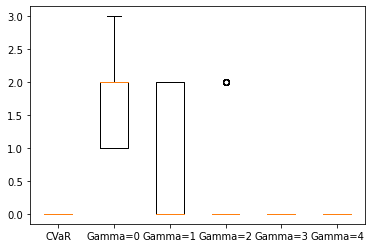

In [45]:
data=(tuple(penalty),)
l=["CVaR"]
for g in range(5):
  robust(ship_num,stack_num,height,n,g,1000,OR=OR)
  data+=(tuple(penalty_r),)
  l.append("Gamma="+str(g))
# print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)

## BRP

In [80]:
# nと初期配置を変更しなければいけない
ship_num=3
stack_num=4
height=4
num=8

O1=[i+1 for i in range(ship_num)]

Q=[i+1 for i in range(stack_num)]
L=[i+1 for i in range(height)]
P=[i+1 for i in range(ship_num)]
# I=[i+1 for i in range(num)]
I=[1,1,3,4,5,6,7,8]
f=stack_num*height-len(I)
time = 3*len(I)
T=[i+1 for i in range(time)]

In [82]:
m=Model("BRP")

# 変数の定義
b,v,x,y={},{},{},{}
for i in Q:
  for j in L:
    for n in I:
      for t in T:
        b[i,j,n,t]=m.addVar(vtype="B")
        y[i,j,n,t]=m.addVar(vtype="B")

for n in I:
  for t in T:
    v[n,t]=m.addVar(vtype="B")

for i in Q:
  for j in L:
    for k in Q:
      for l in L:
        for n in I:
          for t in T:
            x[i,j,k,l,n,t]=m.addVar(vtype="B")

for n in I:
  for t in T:
    m.addConstr(quicksum(b[i,j,n,t] for i in Q for j in L)+v[n,t]==1)

for i in Q:
  for j in L:
    for t in T:
      m.addConstr(quicksum(b[i,j,n,t] for n in I)<=1)

for i in Q:
  for j in range(1,len(L)):
    for t in T:
      m.addConstr(quicksum(b[i,j,n,t] for n in I)>=quicksum(b[i,j+1,n,t] for n in I))

for t in T:
  m.addConstr(quicksum(x[i,j,k,l,n,t] for i in Q for j in L for k in Q for l in L for n in I)+quicksum(y[i,j,n,t] for i in Q for j in L for n in I)<=1)

for n in range(1,len(I)):
  m.addConstr(quicksum(v[n,t] for t in T)>=quicksum(v[n+1,t] for t in T)+1)

for i in Q:
  for j in L:
    for n in I:
      for t in range(2,len(T)+1):
        m.addConstr(b[i,j,n,t]==b[i,j,n,t-1]+quicksum(x[k,l,i,j,n,t-1] for k in Q for l in L)-quicksum(x[i,j,k,l,n,t-1] for k in Q for l in L)-y[i,j,n,t-1])

for n in I:
  for t in T:
    m.addConstr(v[n,t]==quicksum(y[i,j,n,t_] for i in Q for j in L for t_ in range(1,t)))

m.setObjective(quicksum(v[len(I),t] for t in T),GRB.MAXIMIZE)

AttributeError: 'int' object has no attribute 'addConstr'

In [78]:
m.addConstr(b[1,1,8,1]==1)
m.addConstr(b[1,2,7,1]==1)
m.addConstr(b[1,3,6,1]==1)
m.addConstr(b[2,1,1,1]==1)
m.addConstr(b[3,1,1,1]==1)
m.addConstr(b[3,2,3,1]==1)
m.addConstr(b[3,3,4,1]==1)
m.addConstr(b[3,4,5,1]==1)

<gurobi.Constr *Awaiting Model Update*>

In [79]:
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4039 rows, 55488 columns and 196184 nonzeros
Model fingerprint: 0x87fce3b0
Variable types: 0 continuous, 55488 integer (55488 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 17 rows and 5136 columns
Presolve time: 0.07s

Explored 0 nodes (0 simplex iterations) in 0.23 seconds (0.04 work units)
Thread count was 1 (of 8 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -


In [74]:
print("the objective function", len(T)-m.objVal)
#   print("VaR=",alpha.X)

the objective function 11.0


In [75]:
EPS=1.e-5
for (n,t) in v:
  if t!=1:
    if (v[n,t].X-v[n,t-1].X)>EPS:
      print("v[%2s,%2s]=%3s" %(n,t,v[n,t].X))

v[ 1, 5]=1.0
v[ 2, 6]=1.0
v[ 3, 7]=1.0
v[ 4, 8]=1.0
v[ 5, 9]=1.0
v[ 6,10]=1.0
v[ 7,11]=1.0
v[ 8,12]=1.0


## 不確実性集合の作成

In [158]:
G=[]
U=[1,2,3,4]
tmp=U[0]
for i in range(len(U[0])-1):
  U[0][i],U[0][i+1]=U[0][i+1],U[0][i]
  U.append(U[0])
  U[0]=tmp
U

[[2, 3, 4, 1], [2, 3, 4, 1], [2, 3, 4, 1], [2, 3, 4, 1]]

In [133]:
def swap(U):
  # for i in range(len(U)-1):
  U[i],U[i+1]=U[i+1],U[i]
  return U

In [152]:
U=[[1,2,3,4]]
U.append([])
U[1]=[2]
U

[[1, 2, 3, 4], [2]]

In [146]:
U=[1,2,3,4]
swap0(U[0],U[1])

(2, 1)